# `TruckPassErosion` component tutorial

The goal of this Landlab component is to calculate sediment depths for forest road cross section layers based on traffic-induced, erosion-enhancing processes: pumping, crushing, scattering (and by default, flow rerouting). Note that this is a net-zero component (i.e., the overall mass balance is 0).

<p align="center" width="100%">
    <img src="../TruckPassErosion_Component.png" width="60%">
</p>

#### References
Alvis, A. D., Luce, C. H., & Istanbulluoglu, E. (2023). How does traffic 
affect erosion of unpaved forest roads? Environmental Reviews, 31(1), 
182–194. https://doi.org/10.1139/er-2022-0032


## Load necessary `python` packages and set some defaults

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from landlab import RasterModelGrid 
from landlab.components import TruckPassErosion
from landlab.plot.imshow import imshow_grid

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'normal'

## Creating a synthetic grid

For this tutorial, we're going to create a synthetic grid (i.e., make our own DEM!) with a ditch line. We're going to develop a `python` function so we can easily change node spacing depending on whether we're using a node size of a full-tire width or a half-tire-width. We'll call `ErodibleGrid` before we run our `TruckPassErosion` component.

Within `ErodibleGrid`, we call Landlab's `RasterModelGrid` to create a raster grid, and we add a few fields to the grid (e.g., `'topographic__elevation'`, `'roughness'`) with data.

In [2]:
# Create erodible grid function
def ErodibleGrid(nrows, ncols, spacing, full_tire):
    mg = RasterModelGrid((nrows,ncols),spacing)
    z = mg.add_zeros('topographic__elevation', at='node') #create the topographic__elevation field
    road_flag = mg.add_zeros('flag', at='node') #create a road_flag field for determining whether a 
                                                #node is part of the road or the ditch line
    n = mg.add_zeros('roughness', at='node') #create roughness field
    
    mg.set_closed_boundaries_at_grid_edges(False, False, False, False) 
    
    if full_tire == False: #When node spacing is half-tire-width
        road_peak = 40 #peak crowning height occurs at this x-location
        up = 0.0067 #rise of slope from ditchline to crown
        down = 0.0067 #rise of slope from crown to fillslope
        
        for g in range(nrows): #loop through road length
            elev = 0 #initialize elevation placeholder
            flag = False #initialize road_flag placeholder
            roughness = 0.1 #initialize roughness placeholder   

            for h in range(ncols): #loop through road width
                if h == 0 or h == 8:
                    elev = 0
                    flag = False
                    roughness = 0.1
                elif h == 1 or h == 7:
                    elev = -0.333375
                    flag = False
                    roughness = 0.1
                elif h == 2 or h == 6:
                    elev = -0.5715
                    flag = False
                    roughness = 0.1
                elif h == 3 or h == 5:
                    elev = -0.714375
                    flag = False
                    roughness = 0.1
                elif h == 4:
                    elev = -0.762
                    flag = False
                    roughness = 0.1
                elif h <= road_peak and h > 8: #update latitudinal slopes based on location related to road_peak
                    elev += up
                    flag = True
                    roughness = 0.05
                else:
                    elev -= down
                    flag = True
                    roughness = 0.05

                z[g*ncols + h] = elev #update elevation based on x & y locations
                road_flag[g*ncols+h] = flag #update road_flag based on x & y locations
                n[g*ncols + h] = roughness #update roughness values based on x & y locations
    elif full_tire == True: #When node spacing is full-tire-width
        road_peak = 20 #peak crowning height occurs at this x-location
        up = 0.0134 #rise of slope from ditchline to crown
        down = 0.0134 #rise of slope from crown to fillslope
        
        for g in range(nrows): #loop through road length
            elev = 0 #initialize elevation placeholder
            flag = False #initialize road_flag placeholder
            roughness = 0.1 #initialize roughness placeholder

            for h in range(ncols): #loop through road width
                if h == 0 or h == 4:
                    elev = 0
                    flag = False
                    roughness = 0.1
                elif h == 1 or h == 3:
                    elev = -0.5715
                    flag = False
                    roughness = 0.1
                elif h == 2:
                    elev = -0.762
                    flag = False
                    roughness = 0.1
                elif h <= road_peak and h > 4: #update latitudinal slopes based on location related to road_peak
                    elev += up
                    flag = True
                    roughness = 0.05
                else:
                    elev -= down
                    flag = True
                    roughness = 0.05

                z[g*ncols + h] = elev #update elevation based on x & y locations
                road_flag[g*ncols+h] = flag #update road_flag based on x & y locations
                n[g*ncols + h] = roughness #update roughness values based on x & y locations
        
    z += mg.node_y*0.05 #add longitudinal slope to road segment
    road_flag = road_flag.astype(bool) #Make sure road_flag is a boolean array
                
    return(mg, z, road_flag, n)  

### Create grid using half-tire-width node spacing

We'll first call `ErodibleGrid` with the values needed to create a synthetic grid that is ~80m long by ~10.5m wide (including the ditch line) using half-tire-width node spacing (~0.15m). We'll also add small perturbations to the road surface such that there is a slightly more interesting topography.

In [3]:
mg, z, road_flag, n = ErodibleGrid(540,72,0.1475,False) #False indicates we're using half tire width
noise_amplitude=0.007 #to create small perturbations in the road surface

z[road_flag==1] += + noise_amplitude * np.random.rand(
    len(z[road_flag==1])
)

#add sediment depth fields that will update in the component
mg.at_node['active__depth'] = np.ones(540*72)*0.02
mg.at_node['surfacing__depth'] = np.ones(540*72)*0.23
mg.at_node['ballast__depth'] = np.ones(540*72)*2.0

#add absolute elevation fields to the grid that will update based on changes in z
mg.at_node['active__elev'] = z
mg.at_node['surfacing__elev'] = z - mg.at_node['active__depth']
mg.at_node['ballast__elev'] = z - mg.at_node['active__depth']\
     - mg.at_node['surfacing__depth']

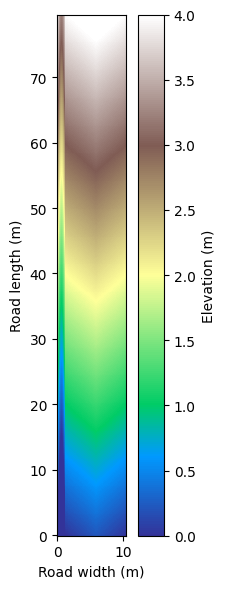

In [4]:
# Plot initial grid
plt.figure(figsize = (3,6), layout='tight')
im = imshow_grid(mg, z, allow_colorbar=False, grid_units = ('m','m'), cmap = 'terrain', vmin = 0, vmax = 4)
cb = plt.colorbar()
cb.set_label('Elevation (m)')
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.tight_layout()
plt.show()

In [5]:
# Prep some variables for later
xsec_pre = mg.at_node['topographic__elevation'][4392*2:4428*2].copy() #This is the initial road surface--saving for comparison

X = mg.node_x.reshape(mg.shape)

## Running the `TruckPassErosion` component

To run `TruckPassErosion`, like all `landlab` components, there are two main steps:
1. Initialize the component
2. Use the `run_one_step()` method of the component

To initialize the component, you call the component and feed it the parameters that it asks for. Let's look at the parameters we can pass to `TruckPassErosion`.

In [6]:
TruckPassErosion?

Init signature:
TruckPassErosion(
    grid,
    centerline,
    half_width,
    full_tire,
    truck_num=5,
    u_ps=5e-07,
    u_pb=1e-07,
    k_cs=1e-07,
    k_cb=1e-07,
    f_af=0.25,
    f_ac=0.75,
    f_sf=0.275,
    f_sc=0.725,
    f_bf=0.2,
    f_bc=0.8,
    scat_loss=8e-05,
)
Docstring:     
Calculate sediment depths for forest road cross section layers based
on traffic-induced, erosion-enhancing processes: pumping, crushing,
scattering (and by default, flow rerouting).

References
----------
Alvis, A. D., Luce, C. H., & Istanbulluoglu, E. (2023). How does traffic 
affect erosion of unpaved forest roads? Environmental Reviews, 31(1), 
182–194. https://doi.org/10.1139/er-2022-0032
Init docstring:
Initialize TruckPassErosion.

Parameters
----------
grid : ModelGrid
    Landlab ModelGrid object
truck_num : int
    Average number of trucks to pass over a road segment in a day
centerline : arraylike of int
    The location of the centerline of the road surface. 
    If using a real 

There are a number of parameters that *can* be passed to `TruckPassErosion`, but there are only 4 required parameters: the grid itself, the centerline of the road surface (either as a single node or an array of nodes), the half width of the truck (in number of nodes), and a flag to indicate whether the node spacing is for a full tire width or half tire width. So to initialize `TruckPassErosion`, we can define necessary parameters, then run a single line of code:

In [7]:
center = 40 #center node of the road
half_width = 7 #how far each tire extends from center
full_tire = False

tpe = TruckPassErosion(mg, center, half_width, full_tire) #initialize component

Next, we need to call the `run_one_step()` method of `TruckPassErosion`. No additional parameters are required for this method. This is where we "run the model" (i.e., each `run_one_step()` method call is a single timestep for the overall model.)

In [8]:
import time #to see how long it takes to run this component!
start = time.time()

#define how long to run the model
model_end = 90 #days
for i in range(0, model_end): #loop through model days
    tpe.run_one_step() #call the method

end = time.time()
print(f"Time taken to run the code was {end-start} seconds")

Time taken to run the code was 2.7911202907562256 seconds


## Looking at the results

The component runs very quickly, and now we can look at the results. We should see rutting in the road surface due to truck passes. We'll look at this both as a cross section and as a map.

### Cross section

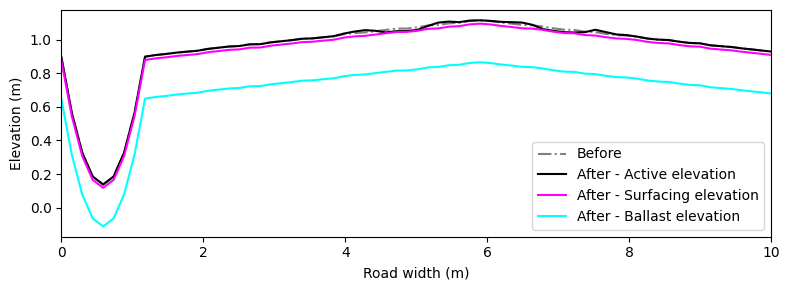

In [9]:
xsec_active = mg.at_node['active__elev'][4392*2:4428*2] #active layer elevation
xsec_surf =  mg.at_node['surfacing__elev'][4392*2:4428*2] #surfacing layer elevation
xsec_ball = mg.at_node['ballast__elev'][4392*2:4428*2] #ballast layer elevation

plt.figure(figsize=(8,3), layout='tight')
plt.plot(X[36], xsec_pre, color='gray', linestyle='-.', label='Before') #this is the saved array from earlier
plt.plot(X[36], xsec_active, color ='black', linestyle='-', label = 'After - Active elevation')
plt.plot(X[36], xsec_surf, color ='magenta', linestyle='-', label = 'After - Surfacing elevation')
plt.plot(X[36], xsec_ball, color ='cyan', linestyle='-', label = 'After - Ballast elevation ')
plt.xlim(0,10)
plt.xlabel('Road width (m)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.show()

### Map

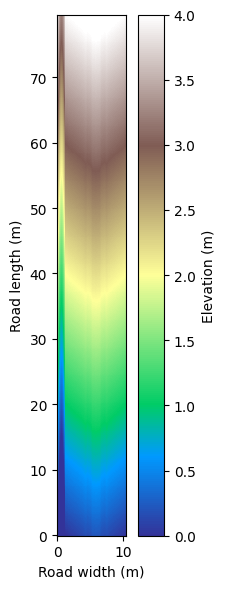

In [10]:
# 2D rill plot
plt.figure(figsize = (3,6), layout='tight')
im = imshow_grid(mg, z, allow_colorbar=False, grid_units = ('m','m'), cmap = 'terrain', vmin = 0, vmax = 4)
cb = plt.colorbar()
cb.set_label('Elevation (m)')
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.tight_layout()
plt.show()

## Start again!
### This time, we'll create a grid using full-tire-width node spacing

In [11]:
mg, z, road_flag, n = ErodibleGrid(270,36,0.295,True) #full tire width
noise_amplitude=0.007

z[road_flag==1] += + noise_amplitude * np.random.rand(
    len(z[road_flag==1])
)

#add depth fields that will update in the component
mg.at_node['active__depth'] = np.ones(270*36)*0.02
mg.at_node['surfacing__depth'] = np.ones(270*36)*0.23
mg.at_node['ballast__depth'] = np.ones(270*36)*2.0

#add absolute elevation fields that will update based on z updates
mg.at_node['active__elev'] = z
mg.at_node['surfacing__elev'] = z - mg.at_node['active__depth']
mg.at_node['ballast__elev'] = z - mg.at_node['active__depth']\
     - mg.at_node['surfacing__depth']


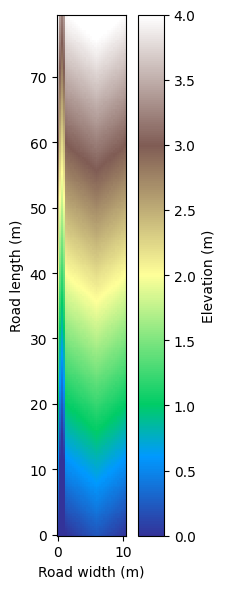

In [12]:
# Plot initial grid
plt.figure(figsize = (3,6), layout='tight')
im = imshow_grid(mg, z, allow_colorbar=False, grid_units = ('m','m'), cmap = 'terrain', vmin = 0, vmax = 4)
cb = plt.colorbar()
cb.set_label('Elevation (m)')
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.tight_layout()
plt.show()

In [13]:
# Prep some variables for later
xsec_pre = mg.at_node['topographic__elevation'][2196:2232].copy()

X = mg.node_x.reshape(mg.shape)

In [14]:
center = 20 #center node
half_width = 4
full_tire = True

tpe = TruckPassErosion(mg, center, half_width, full_tire) #initialize component

In [15]:
import time
start = time.time()

#define how long to run the model
model_end = 90 #days

for i in range(0, model_end): #loop through model days
    tpe.run_one_step()

end = time.time()
print(f"Time taken to run the code was {end-start} seconds")

Time taken to run the code was 0.46723055839538574 seconds


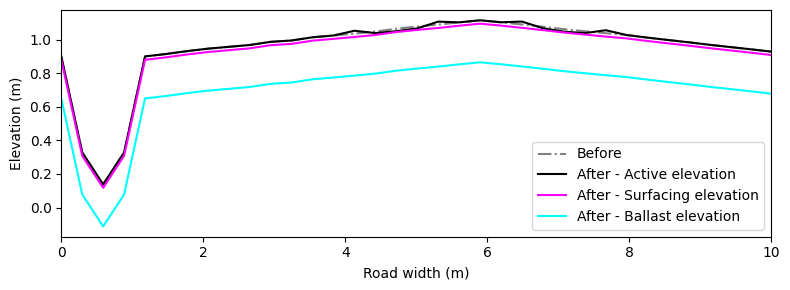

In [16]:
xsec_active = mg.at_node['active__elev'][2196:2232]
xsec_surf =  mg.at_node['surfacing__elev'][2196:2232] 
xsec_ball = mg.at_node['ballast__elev'][2196:2232]

plt.figure(figsize=(8,3), layout='tight')
plt.plot(X[36], xsec_pre, color='gray', linestyle='-.', label='Before')
plt.plot(X[36], xsec_active, color ='black', linestyle='-', label = 'After - Active elevation')
plt.plot(X[36], xsec_surf, color ='magenta', linestyle='-', label = 'After - Surfacing elevation')
plt.plot(X[36], xsec_ball, color ='cyan', linestyle='-', label = 'After - Ballast elevation ')
plt.xlim(0,10)
plt.xlabel('Road width (m)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.show()

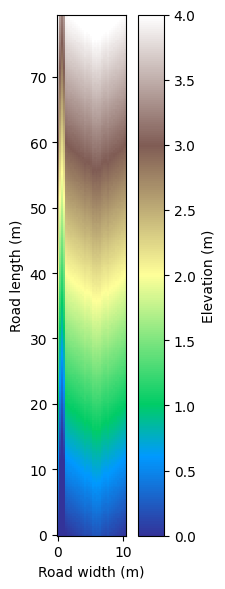

In [17]:
# 2D rill plot
plt.figure(figsize = (3,6), layout='tight')
im = imshow_grid(mg, z, allow_colorbar=False, grid_units = ('m','m'), cmap = 'terrain', vmin = 0, vmax = 4)
cb = plt.colorbar()
cb.set_label('Elevation (m)')
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.tight_layout()
plt.show()